# Form factor of a two-boson bound state
The form factor of a two-boson bound state is computed using numerical Gauss-Legendre integration. The wave functions are given on a discrete grid (of momenta) by numerical solution of the Schrödinger equation as was shown and provided by Andreas Nogga in the lecture.

## Theory
The wave functions were obtained by solving the discretized Schrödinger equation in momentum space
\begin{equation}
\psi_l(p_i) = \frac{1}{E-\frac{p_i^2}{2\mu_{12}}} \sum_j w_j \, p_j^2 V_l(p_i,p_j) \ \psi_l(p_j) \  .
\end{equation}
Where the potential is given by $$ V(\vec p, \vec p') = \frac{A}{2\pi} \frac{1}{(\vec p - \vec p')^2 + m_B^2} \exp\left(-\frac{(\vec p - \vec p')^2 + m_B^2}{\Lambda^2 }\right) + \frac{C_0}{4 \pi } \exp\left( - \frac{p^2+{p'}^2}{\Lambda^2}\right), $$
with $p,p'$ the momenta before and after interaction respectively, pion mass $m_B=138$ MeV $\Lambda$ 

*1. Confirm that the form factor can be obtained based on the internal wave functions as*
\begin{equation*}
        F(\vec{q}^2)=\int d^3p'\psi^*(\vec{p}')\psi(\vec{p}'-\frac{1}{2}\vec{q})
\end{equation*}



*2. Express this relation in terms of partial wave amplitudes. In order to simplify the expression, you can assume that $\vec{q}=q\vec{e_z}$ and that only the partial wave $ll_z$ contributes to the bound state wave function. In this case, $l_z$ is conserved and the solid angle integration can be simplified to the integration over $x = \cos(\theta)$. Verify the relation*

\begin{equation*}
        F(\vec{q}^2)=2\pi\int dp'p'^2\int_{-1}^{1}dx Y_{ll_z}^*(\hat{p}')Y_{ll_z}^*(\widehat{\vec{p}'-\frac{1}{2}\vec{q}})\psi_{ll_z}^*(p')\psi_{ll_z}^*(|\vec{p}'-\frac{1}{2}\vec{q}|).
\end{equation*}

*In this relation, the momentum is given by $\vec{p}'=(p'\sqrt{1-x^2},0,p'x)$*

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre
from scipy.special import sph_harm
from scipy.interpolate import interp1d
from functions import * #Import the functions given in the lecture  

import matplotlib.pyplot as plt


In [2]:
hbarc = 197.327 
Lambda = [300+i*100 for i in range(0, 10)]
C0 = [-9.827953*1e-2, -2.820315*1e-02,  -4.221894*1e-04, 1.285743*1e-02,
      2.016719*1e-02,  2.470795*1e-02, 2.786520*1e-02,  3.030801*1e-02,
     3.239034*1e-02,  3.431611*1e-02]
nx =20
mpi = 138
A = -0.1544435
E = -2.225/hbarc
neigv = 1
cutoff=Lambda


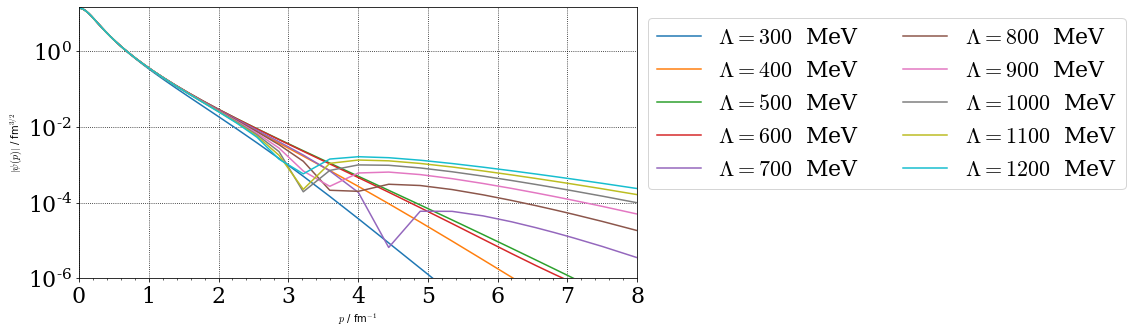

In [3]:
beauty_plot()
plt.xlim(0,8)
plt.ylim(1E-6,15)
p_list = []
weight_list=[]
psi_list = []
for i in range(len(Lambda)):
    pot = OBEpot(nx=nx,mpi=mpi,C0=C0[i],A=A,cutoff=Lambda[i])
    solver=TwoBody(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    p_list.append(solver.eigv(E, neigv)[1])
    weight_list.append(solver.pweight)
    psi_list.append(solver.eigv(E, neigv)[-1])
    plt.plot(p_list[i],np.abs(psi_list[i]), label="$\Lambda=%d$  MeV"%(Lambda[i]))
plt.yscale('log')
plt.tick_params(axis='y', which='minor')
plt.xlabel("$p$ / fm$^{-1}$")
plt.ylabel('$|\psi(p)|$ / fm$^{3/2}$')
plt.legend(bbox_to_anchor=(1,1), ncol=2)
plt.show()


Implement the form factor based on the wave functions obtained in the lecture that are defined on a finite grid (you may extend the notebook provided and reuse the TwoBody class). Hint: the wave function $\psi_{llz}(|\vec{p}'-\frac{1}{2}\vec{q}|)$ at momenta different from the momentum grid can be obtained using (cubic) splines. Argument of the spherical
harmonic $\vec{p}'-1/2\vec{q}$ is easiest obtained in terms of its x and z component. How do you
get the angles from these components?

In [4]:
def Formfactor(q,p,weight,wf,nx,m,n):
    x,xweight=leggauss(nx)
    theta = np.arccos(x)
    phi=0
    #theta=arccos(z/r)
    theta_prime = [np.arccos((p *x -1/2*q)/(np.sqrt(p**2-p*x*q+1/4*q**2))) for p in p]
    phi_prime=0 #phi = arctan(y/x)
    #sph_harm uses opposite convention for theta and phi
    angle_int=[np.sum(sph_harm(m,n,phi,theta)*sph_harm(m,n,phi,theta_prime)*xweight) for theta_prime in theta_prime] # calculate integral for each p (theta_prime)
    inter= interp1d(p, wf, kind='cubic',fill_value="extrapolate") 
    wf_inter=inter(np.abs(p-1/2*q))#interpolate the wf to the grid p-1/2q
    p_int=np.sum(p**2*angle_int*wf*wf_inter*weight)
    return np.real(p_int*2*np.pi)

*4. Use the wave function for $\Lambda = 1200$ MeV and selected momentum transfers $|\vec{q}|$ in the
range up to 10 fm$^{-1}$  to check the numerical accuracy of your result, especially with
respect to the number of grid points used for angular integration*

In [5]:
nx_list=[8+2*i for i in range(10)]
f_list_1=[Formfactor(10,p_list[-1],weight_list[-1],psi_list[-1],nx,1,1) for nx in nx_list]
f_list_2=[Formfactor(5,p_list[-1],weight_list[-1],psi_list[-1],nx,1,1) for nx in nx_list]
f_list_3=[Formfactor(0,p_list[-1],weight_list[-1],psi_list[-1],nx,1,1) for nx in nx_list]
f_list=[f_list_1,f_list_2,f_list_3]
table = {"nx":nx_list, "q=10 fm$^{-1}$":f_list_1, "q=5 fm$^{-1}$":f_list_2, "q=0 fm$^{-1}$":f_list_3}
table = pd.DataFrame(data=table)
table.style.hide_index()

nx,q=10 fm$^{-1}$,q=5 fm$^{-1}$,q=0 fm$^{-1}$
8,-0.199421,0.275686,1.000000
10,-0.199358,0.275607,1.000000
12,-0.199329,0.275572,1.000000
14,-0.199314,0.275555,1.000000
16,-0.199306,0.275546,1.000000
18,-0.199301,0.275540,1.000000
20,-0.199297,0.275537,1.000000
22,-0.199295,0.275535,1.000000
24,-0.199294,0.275533,1.000000
26,-0.199293,0.275532,1.000000


We find that for nx=20 the accuracy is sufficient to up to 4 digits.

*5. Show that
\begin{align}
    F(0)=1 &&\text{and}&& \frac{\partial F(\vec{q}^2)}{\partial \vec{q}^2}=-\frac{1}{6}\langle r^2\rangle
\end{align}
where $\langle r^2\rangle$
i is the expectation value of the square of the position of the first particle with
respect to the center of mass. Confirm that your code reproduces the normalization of
the form factor and the rms radius known from the Fourier transformation. Hint: the
derivative can also be obtained by fitting F at low momentum transfers to q polynomial
in $\vec{q}^2$. The python package “lmfit” provides the necessary tools*

As shown in the tabular above, F(0)=1 independent of the grid size nx.

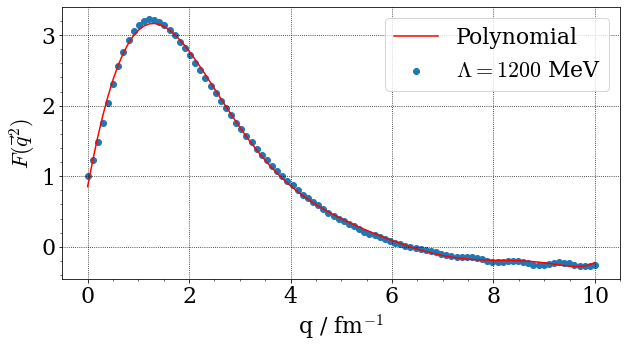

In [6]:
q_list = np.linspace(0,10,100)
np.delete(q_list,0)
F_q = [Formfactor(q,p_list[-1],weight_list[-1],psi_list[-1],20,0,0) for q in q_list]
z = np.polyfit(q_list,F_q,8)
polynomial = np.poly1d(z)
derivative = np.polyder(polynomial)
beauty_plot()
plt.scatter(q_list,F_q, zorder=-1, label="$\Lambda=1200$ MeV")
plt.plot(q_list, polynomial(q_list), color="red", label="Polynomial")
plt.legend()
plt.xlabel("q / fm$^{-1}$")
plt.ylabel("$F(\\vec{q}^2)$")
plt.show()

In [7]:
wfr = solver.fourier(np.array(psi_list[-1]))
rms = solver.rms(wfr[1])[1]
np.real(-1/6*rms)

-0.6902872978878618

In [8]:
derivative(4)

-0.6189980248953066

*6. Plot form factor for several $\Lambda$ in the range $\vec{q} = 0−10 $fm$^{-1}$  and briefly discuss differences and similarities at low and high momenta.*

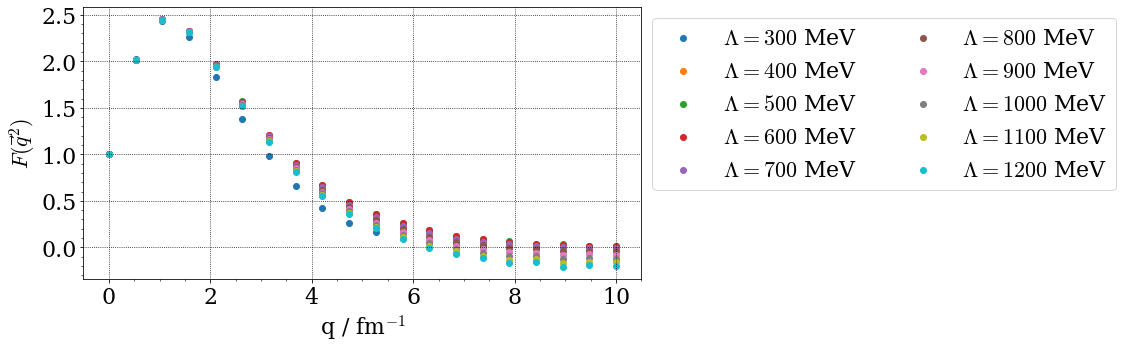

In [17]:
beauty_plot()
p_list = []
weight_list=[]
psi_list = []
for i in range(len(Lambda)):
    pot = OBEpot(nx=nx,mpi=mpi,C0=C0[i],A=A,cutoff=Lambda[i])
    solver=TwoBody(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    p_list.append(solver.eigv(E, neigv)[1])
    weight_list.append(solver.pweight)
    psi_list.append(solver.eigv(E, neigv)[-1])
    q_list = np.linspace(0,10,20)
    F_q = [Formfactor(q,p_list[i],weight_list[i],psi_list[i],20,1,1) for q in q_list]
    plt.scatter(q_list, F_q, label="$\Lambda = %d$ MeV"%(Lambda[i]))
    
plt.legend(bbox_to_anchor=(1,1), ncol=2)
plt.xlabel("q / fm$^{-1}$")
plt.ylabel("$F(\\vec{q}^2)$")
plt.show()

For small $q$ the difference in the form factor is small. For growing $q$'s after the first maximum it converges for all $\Lambda$'s against 0, but faster for small $\Lambda$'s.